Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-83-1c60789163ee>:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  T = random.sample(set(range(N)) - set(S), 8)


Statut: Infeasible
Le valeur de la fonction objectif (cout minimal): 6323.0
Le flot de la solution optimale : 
Flot de 0 à 16 : 98.0
Flot de 3 à 19 : 9.0
Flot de 3 à 0 : 4.0
Flot de 4 à 10 : 166.0
Flot de 4 à 19 : 17.0
Flot de 6 à 3 : 13.0
Flot de 8 à 18 : 98.0
Flot de 10 à 0 : 94.0
Flot de 10 à 19 : 72.0
Flot de 12 à 5 : 6.0
Flot de 15 à 1 : 98.0
Flot de 16 à 4 : 183.0
Flot de 16 à 15 : 98.0
Flot de 18 à 5 : 92.0
Flot de 19 à 8 : 98.0


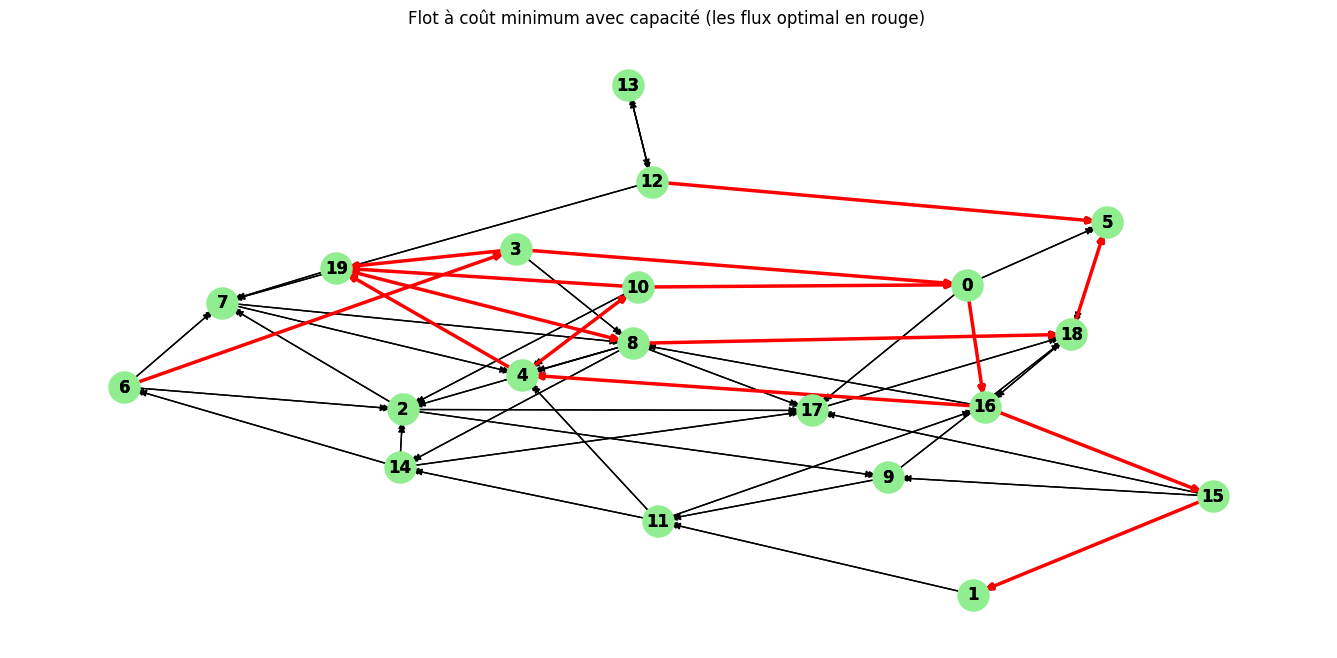

In [ ]:
!pip install pulp
import random
import networkx as nx
import matplotlib.pyplot as plt
import pulp


# Définir les paramètres du graphe
N = 20 # nombres des noeuds
A = 50 # nombres des arcs
C = 10 # coût unitaire d'un arc
U = 20 # capacité maximale d'un arc


# Créer un graphe orienté aléatoire
G= nx.gnm_random_graph(20, 50, seed=11155441, directed=True)

for (u, v) in G.edges():
    G.edges[u, v]['capacité'] = random.randint(0, U)
    G.edges[u, v]['coût'] = random.randint(0, C)

# Définir les sources et les destinations
S = random.sample(range(N), 5)
T = random.sample(set(range(N)) - set(S), 8)

# Définir les valeurs d'offre et de demande
ds = sum(random.randint(0, U) for i in S)
dt = sum(random.randint(0, U) for i in T)


# Créer le problème de flot à résoudre
prob = pulp.LpProblem("Flot à coût minimum avec capacité", pulp.LpMinimize)

# Définir les variables de décision (en meme temps on a donner la contrainte de Non-negativite avec l'argument lowBound=0. Cela garantira que toutes les variables de décision sont supérieures ou égales à zéro)
flux = pulp.LpVariable.dicts("Flot", G.edges(), lowBound=0, cat=pulp.LpContinuous)

# Définir la fonction objectif
prob += pulp.lpSum([G.edges[u, v]['coût'] * flux[u, v] for (u, v) in G.edges()])

# Définir les contraintes de capacité
for (u, v) in G.edges():
    prob += flux[u, v] <= G.edges[u, v]['capacité']

# Définir les contraintes de conservation de flot
for i in range(N):
    if i in S:
        prob += pulp.lpSum([flux[u, v] for (u, v) in G.edges() if u == i]) == ds
    elif i in T:
        prob += pulp.lpSum([flux[u, v] for (u, v) in G.edges() if v == i]) == dt
    else:
        prob += pulp.lpSum([flux[u, v] for (u, v) in G.edges() if u == i]) == pulp.lpSum([flux[u, v] for (u, v) in G.edges() if v == i])

# Résoudre le problème de flot
prob.solve()

# Afficher la solution
print("Statut:", pulp.LpStatus[prob.status])
print("Le valeur de la fonction objectif (coût minimum):", pulp.value(prob.objective))
print("Le flot de la solution optimale : ")
for (u, v) in G.edges():
    if flux[u, v].varValue > 0:
        print("Flot de", u, "à", v, ":", flux[u, v].varValue)

# Créer un nouveau graphe avec seulement les arcs avec un flot non nul en rouge
H = nx.DiGraph()
for (u, v) in G.edges():
    if flux[u, v].varValue > 0:
        H.add_edge(u, v, capacity=G.edges[u, v]['capacité'], flux=flux[u, v].varValue)

# Afficher le graphe avec tous les arcs en vert et les arcs avec flot en rouge
fig, ax = plt.subplots(figsize=(17,8))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightgreen', font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_edges(H, pos, ax=ax, width=2.5, edge_color='red')
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in G.nodes()}, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, font_weight='bold')
plt.title("Flot à coût minimum avec capacité (les flux optimal en rouge) ")
plt.show()

